In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import json

In [3]:
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["font.size"] = 18  # Adjust the font size
colors = ['#ccebc5', '#7bccc4', '#2b8cbe','#084081']


def read_text_files(directory,component,number,label):
    text_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            with open(os.path.join(directory, filename), 'r') as file:
                d={
                'In-Flight':0,
                'Throughput':0,
                'Latency(ms)': 0,
                'ScaleFactor': component,
                "# of Components":number,
                "Label":label
                }
                for line in file:
                    if line.startswith("In-Flight Requests"):
                        inFlight = int(line.split(' ')[2].strip())
                        d['In-Flight']=inFlight
                    if line.startswith("Ops/s"):
                        parts = line.split(',')
                        throughput = int(parts[1])
                        d['Throughput']=throughput/30
                    
                    if line.startswith("Average Latency"):
                        latency = int(line.split(' ')[2])
                        d['Latency(ms)']=latency
                
                text_data.append(d)
    return text_data



In [4]:
scaleOneWaffleBDB = '/home/haseeb/Desktop/ReviewGraphs/ObliviousBaseline/Waffle_BDB' 

scaleOneORAMBDB = '/home/haseeb/Desktop/ReviewGraphs/ObliviousBaseline/ORAM_BDB' 

waffleBDB = pd.DataFrame(read_text_files(scaleOneWaffleBDB,'Waffle',1,"Waffle"))
oRAMBDB = pd.DataFrame(read_text_files(scaleOneORAMBDB,'ORAM',1,"ORAM"))

ObliDBDF = pd.read_csv("/home/haseeb/Desktop/ReviewGraphs/ObliviousBaseline/ObliDB/tabledData.csv")

ObliviatorDF = pd.read_csv("/home/haseeb/Desktop/ReviewGraphs/ObliviousBaseline/Obliviator/obliviator.csv")

# Calculate the average RoundTripTime (s) for each Category
avg_rtt = ObliviatorDF.groupby("Category")["RoundTripTime(s)"].mean()

avg_rtt_df = avg_rtt.reset_index()
avg_rtt_df['Throughput'] = 1/avg_rtt_df['RoundTripTime(s)']



# avg_rtt_df


Obliviator: 71.57794351118258
Waffle: 556.0555555555555
ORAM: 117.68888888888888
ObliDB: 96.66000000000001


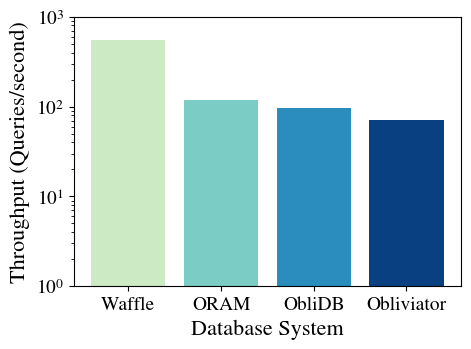

In [6]:
## Manually calculate weighted Average for Obliviator since Run time is too long to have client call join only 5% of the time 
## Since this requires a lot of queries.

weights = {'Join': 0.05, 'Point': 0.475, 'Range': 0.475}
avg_rtt_df['Weight'] = avg_rtt_df['Category'].map(weights)
weighted_mean_obliviator = (avg_rtt_df['Throughput'] * avg_rtt_df['Weight']).sum() / avg_rtt_df['Weight'].sum()


###


## Client already takes care of only doing 5% join in these
waffleBDBMean = waffleBDB['Throughput'].mean()
oRAMBDBMean = oRAMBDB['Throughput'].mean()
ObliDBMean = ObliDBDF['Throughput (requests/second)'].mean()

print("Obliviator:", weighted_mean_obliviator)
print("Waffle:", waffleBDBMean)
print("ORAM:", oRAMBDBMean)
print("ObliDB:", ObliDBMean)

X = ["Waffle", "ORAM", "ObliDB", "Obliviator"]

# Convert Y from variable names (strings) to their actual values
Y = [waffleBDBMean, oRAMBDBMean, ObliDBMean, weighted_mean_obliviator]

plt.figure(figsize=(5, 3.5))
bars = plt.bar(X, Y, color=colors)
plt.ylabel("Throughput (Queries/second)", fontsize=16)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.yscale('log')
plt.ylim(1, 1000)
plt.xlabel("Database System", fontsize=16)

# Save the figure
plt.savefig("/home/haseeb/Desktop/ReviewGraphs/Figures/ObliviousBaseline.png", format='png', bbox_inches='tight')
plt.show()

In [18]:
weighted_avg_rtt = (avg_rtt_df['RoundTripTime(s)'] * avg_rtt_df['Weight']).sum() / avg_rtt_df['Weight'].sum()
# Convert weighted average RoundTripTime to milliseconds
weighted_avg_rtt_ms = weighted_avg_rtt * 1000
print("Weighted Average RoundTripTime(ms):", weighted_avg_rtt_ms)


Weighted Average RoundTripTime(ms): 17.154933333333332
